# Compare $n_\mathrm{train}$ Dependence for Multiple Statistics and Bias Param Sets

This notebook computes and plots $\chi^2$ and FoM as a function of $n_\mathrm{train}$ for all combinations of statistics and bias parameter sets, for both the CV (fixed-cosmo) and coverage test sets.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader, plotter, plot_utils, utils, generate_params as genp
%load_ext autoreload
%autoreload 2

2025-08-07 19:23:43.155289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 19:23:43.265266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-07 19:23:43.265310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-07 19:23:43.280915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-07 19:23:43.315412: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# --- Config ---
data_mode = 'muchisimocks'
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_params = '_p5_n10000'
tag_biasparams_arr = ['_biaszen_p4_n10000', '_biaszen_p4_n50000', '_biaszen_p4_n100000',  '_biaszen_p4_n200000']
n_train_arr = [500, 1000, 2000, 4000, 6000, 8000, 10000]
dir_results = '/scratch/kstoreyf/muchisimocks/results'

In [3]:
def get_tags_inf(statistics, tag_biasparams, n_train_arr):
    tag_stats = '_' + '_'.join(statistics)
    return [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for n_train in n_train_arr]

In [4]:
param_names = utils.param_names_all_ordered
cosmo_param_names = utils.cosmo_param_names_ordered
bias_param_names = utils.biasparam_names_ordered

In [5]:
def get_param_names(tag_params, tag_biasparams):
    params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)
    cosmo_param_names_vary = params_df.columns.tolist() if params_df is not None else []
    bias_param_names_vary = biasparams_df.columns.tolist() if biasparams_df is not None else []
    return cosmo_param_names_vary, bias_param_names_vary

In [6]:
def get_cv_test_arrays(tags_inf, n_train_arr, statistics, tag_biasparams, cosmo_param_names_vary, bias_param_names_vary):
    tag_params_test_fixed = '_quijote_p0_n1000'
    tag_biasparams_test_fixed = '_b1000_p0_n1'
    tag_datagen_test_fixed = ''
    tag_stats = '_' + '_'.join(statistics)
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean']*len(tags_inf)
    theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, n_train_arr_filtered = [], [], []
    for i, tag_inf in enumerate(tags_inf):
        dir_sbi = f'{dir_results}/results_sbi/sbi{tag_inf}'
        fn_samples_test_pred = f'{dir_sbi}/samples_test{tags_test[i]}_pred.npy'
        if not Path(fn_samples_test_pred).exists():
            print(f"Missing: {fn_samples_test_pred}, skipping n_train={n_train_arr[i]}")
            continue
        theta_test_pred_fixed, covs_test_pred_fixed, _ = utils.get_moments_test_sbi(tag_inf, tag_test=tags_test[i])
        theta_test_pred_fixed_arr.append(theta_test_pred_fixed[0])
        covs_test_pred_fixed_arr.append(covs_test_pred_fixed[0])
        n_train_arr_filtered.append(n_train_arr[i])
    # Load the true test value for the fixed-cosmology test set
    # Use the same param_names as in the predictions
    
    #cosmo_param_names_vary, bias_param_names_vary = get_param_names(tag_params_test_fixed, tag_biasparams_test_fixed)
    theta_test_true = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
    print(theta_test_true)
    # theta_test_true = None
    # if len(theta_test_pred_fixed_arr) > 0:
    #     # Use the param_names from the first available prediction
    #     _, _, param_names = utils.get_moments_test_sbi(tags_inf[0], tag_test=tags_test[0])
    #     theta_test = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed)
    #     # Get the true values in the same order as param_names
    #     idxs = [list(theta_test.dtype.names).index(pn) if hasattr(theta_test, 'dtype') and theta_test.dtype.names else i for i, pn in enumerate(param_names)]
    #     theta_test_true = theta_test[0][idxs] if hasattr(theta_test, 'dtype') and theta_test.dtype.names else theta_test[0]
    return np.array(theta_test_pred_fixed_arr), np.array(covs_test_pred_fixed_arr), n_train_arr_filtered, theta_test_true

In [7]:
def get_coverage_test_arrays(tags_inf, statistics, tag_biasparams, n_train_arr):
    # Coverage test set
    tag_params_test = '_test_p5_n1000'
    tag_biasparams_test = '_biaszen_p4_n1000'
    tag_datagen_test = ''
    tag_stats = '_' + '_'.join(statistics)
    tag_data_test = '_'+data_mode + tag_stats + tag_params_test + tag_biasparams_test + tag_datagen_test
    tags_data_test = [tag_data_test]*len(tags_inf)
    param_names_show = utils.param_names_all_ordered
    theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, n_train_arr_filtered = [], [], [], [], []
    for i, tag_inf in enumerate(tags_inf):
        dir_sbi = f'{dir_results}/results_sbi/sbi{tag_inf}'
        fn_samples_test_pred = f'{dir_sbi}/samples_test{tags_data_test[i]}_pred.npy'
        if not Path(fn_samples_test_pred).exists():
            print(f"Missing: {fn_samples_test_pred}, skipping n_train={n_train_arr[i]}")
            continue
        else:
            print(f"Loading: {fn_samples_test_pred}, n_train={n_train_arr[i]}")
        _theta_test_pred, _covs_test_pred, param_names = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i])
        theta_test = data_loader.load_theta_test(tag_params_test, tag_biasparams_test)
        theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
        for param_name_show in param_names_show:
            if param_name_show in param_names:
                idx_pn = list(param_names).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn])
                theta_pred_inf.append(_theta_test_pred[:,idx_pn])
                vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            else:
                nans = np.full(_theta_test_pred.shape[0], np.nan)
                theta_true_inf.append(nans)
                theta_pred_inf.append(nans)
                vars_pred_inf.append(nans)
        theta_true_arr.append(np.array(theta_true_inf).T)
        theta_pred_arr.append(np.array(theta_pred_inf).T)
        vars_pred_arr.append(np.array(vars_pred_inf).T)
        covs_pred_arr.append(_covs_test_pred)
        n_train_arr_filtered.append(n_train_arr[i])
    return (np.array(theta_true_arr), np.array(theta_pred_arr),
            np.array(vars_pred_arr), np.array(covs_pred_arr), n_train_arr_filtered)

In [8]:
def compute_chi2_fom_cv(theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, theta_test_true):
    chi2_arr, fom_arr = [], []
    for i in range(len(theta_test_pred_fixed_arr)):
        chi2_arr.append(utils.chi2(theta_test_true, theta_test_pred_fixed_arr[i], covs_test_pred_fixed_arr[i]))
        fom_arr.append(utils.figure_of_merit(covs_test_pred_fixed_arr[i]))
    return np.array(chi2_arr), np.array(fom_arr)

def compute_chi2_fom_coverage(theta_true_arr, theta_pred_arr, covs_pred_arr):
    chi2_arr, fom_arr = [], []
    for i in range(len(theta_true_arr)):
        chi2_arr.append(utils.chi2(theta_true_arr[i], theta_pred_arr[i], covs_pred_arr[i]))
        fom_arr.append(utils.figure_of_merit(covs_pred_arr[i]))
    return np.array(chi2_arr), np.array(fom_arr)

In [9]:
# --- Main loop over all combinations ---
results_cv = {}
results_coverage = {}
for statistics in statistics_arr:
    for tag_biasparams in tag_biasparams_arr:
        tags_inf = get_tags_inf(statistics, tag_biasparams, n_train_arr)
        cosmo_param_names_vary, bias_param_names_vary = get_param_names(tag_params, tag_biasparams)
        # CV test set
        param_names_vary = cosmo_param_names_vary + bias_param_names_vary
        theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, n_train_arr_cv, theta_test_true = get_cv_test_arrays(tags_inf, n_train_arr, statistics, tag_biasparams, cosmo_param_names_vary, bias_param_names_vary)
        chi2_cv, fom_cv = compute_chi2_fom_cv(theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, theta_test_true)
        results_cv[(tuple(statistics), tag_biasparams)] = (chi2_cv, fom_cv, n_train_arr_cv)
        # Coverage test set
        theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, n_train_arr_cov = get_coverage_test_arrays(tags_inf, statistics, tag_biasparams, n_train_arr)
        chi2_coverage, fom_coverage = compute_chi2_fom_coverage(theta_true_arr, theta_pred_arr, covs_pred_arr)
        results_coverage[(tuple(statistics), tag_biasparams)] = (chi2_coverage, fom_coverage, n_train_arr_cov)

tag_Anoise_test None
None
{}
9
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
Missing: /scratch/kstoreyf/muchisimocks/results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain500/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=500
Missing: /scratch/kstoreyf/muchisimocks/results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain1000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=1000
Missing: /scratch/kstoreyf/muchisimocks/results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain2000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=2000
Missing: /scratch/kstoreyf/muchisimocks/results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain4000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=4000
Loading: /scratch/kstoreyf/muchisimocks/results/results_sbi/sb

In [10]:
n_dof = len(theta_true_arr[0][0])
n_dof

9

In [11]:
# --- Filtering Configuration ---
# Filter for specific bias parameter set counts (in units of 10,000)
# Set to None to include all, or specify values like [1, 10, 20] to filter
bias_filter_values = [1, 10, 20]  # Will use 10000, 100000, 200000 (omitting 50000)

def apply_bias_filter(results_dict, bias_filter_values=None):
    """Filter results dictionary to only include specified bias parameter set counts"""
    if bias_filter_values is None:
        return results_dict
    
    bias_filter_tags = [f'_biaszen_p4_n{n*10000}' for n in bias_filter_values]
    print(f"Filtering for bias parameter sets: {bias_filter_tags}")
    
    filtered_results = {}
    for key, value in results_dict.items():
        statistics, tag_biasparams = key
        if tag_biasparams in bias_filter_tags:
            filtered_results[key] = value
    return filtered_results

# Apply filters to results
results_cv_filtered = apply_bias_filter(results_cv, bias_filter_values)
results_coverage_filtered = apply_bias_filter(results_coverage, bias_filter_values)

if bias_filter_values is not None:
    print(f"CV results filtered: {len(results_cv_filtered)}/{len(results_cv)} combinations")
    print(f"Coverage results filtered: {len(results_coverage_filtered)}/{len(results_coverage)} combinations")
else:
    print("No filtering applied - showing all bias parameter sets")

Filtering for bias parameter sets: ['_biaszen_p4_n10000', '_biaszen_p4_n100000', '_biaszen_p4_n200000']
Filtering for bias parameter sets: ['_biaszen_p4_n10000', '_biaszen_p4_n100000', '_biaszen_p4_n200000']
CV results filtered: 9/12 combinations
Coverage results filtered: 9/12 combinations


<Figure size 640x480 with 0 Axes>

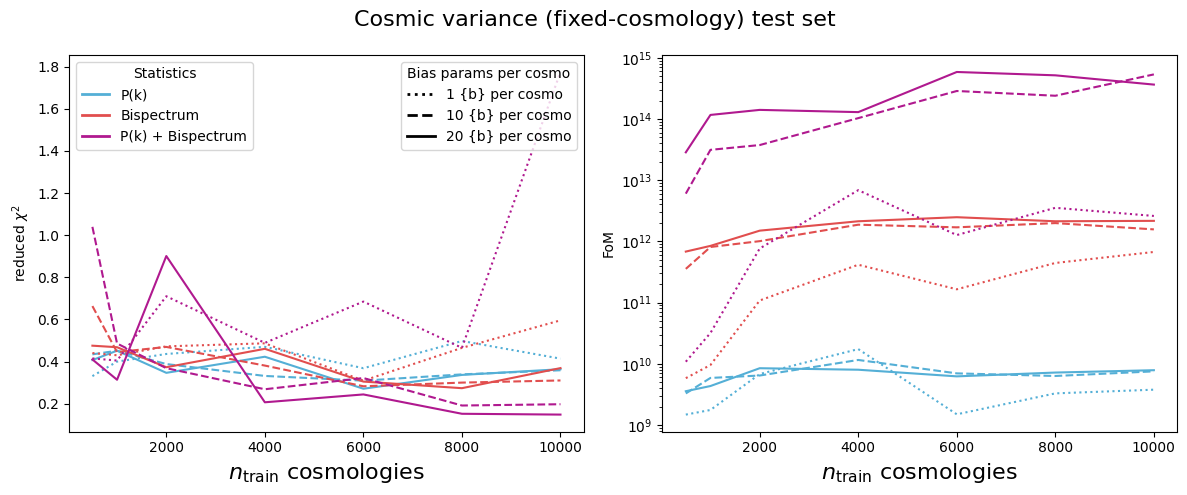

In [12]:
# --- Plotting ---
# Define custom colors for each statistics type
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
color_map = {
    ('pk',): color_pk,
    ('bispec',): color_bispec,
    ('pk', 'bispec'): color_pkbispec
}
linestyle_map = {
    '_biaszen_p4_n10000': ':',
    '_biaszen_p4_n50000': '-.',
    '_biaszen_p4_n100000': '--',
    '_biaszen_p4_n200000': '-',
}

# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Cosmic variance (fixed-cosmology) test set', fontsize=16)

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(results_cv_filtered.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    ax1.plot(n_train_arr_cv, chi2_cv/n_dof, marker=None, color=color, linestyle=linestyle)

ax1.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$')

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(results_cv_filtered.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    ax2.plot(n_train_arr_cv, fom_cv, marker=None, color=color, linestyle=linestyle)

ax2.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM')
ax2.set_yscale('log')

# Create separate legends
from matplotlib.lines import Line2D

# Color legend (statistics types)
color_legend_elements = [
    Line2D([0], [0], color=color_pk, lw=2, label='P(k)'),
    Line2D([0], [0], color=color_bispec, lw=2, label='Bispectrum'),
    Line2D([0], [0], color=color_pkbispec, lw=2, label='P(k) + Bispectrum')
]

# Linestyle legend (bias parameter counts)
# Get the bias parameter counts that are actually shown
shown_bias_tags = set()
for (statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv) in results_cv_filtered.items():
    shown_bias_tags.add(tag_biasparams)

linestyle_legend_elements = []
bias_labels = {
    '_biaszen_p4_n10000': '1 {b} per cosmo',
    '_biaszen_p4_n50000': '5 {b} per cosmo',
    '_biaszen_p4_n100000': '10 {b} per cosmo',
    '_biaszen_p4_n200000': '20 {b} per cosmo'
}

for tag_bias in sorted(shown_bias_tags):
    if tag_bias in linestyle_map and tag_bias in bias_labels:
        linestyle_legend_elements.append(
            Line2D([0], [0], color='black', linestyle=linestyle_map[tag_bias], 
                   lw=2, label=bias_labels[tag_bias])
        )

# Add legends to the left subplot
legend1 = ax1.legend(handles=color_legend_elements, loc='upper left', fontsize=10, title='Statistics')
legend2 = ax1.legend(handles=linestyle_legend_elements, loc='upper right', fontsize=10, title='Bias params per cosmo')
ax1.add_artist(legend1)  # Add the first legend back

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

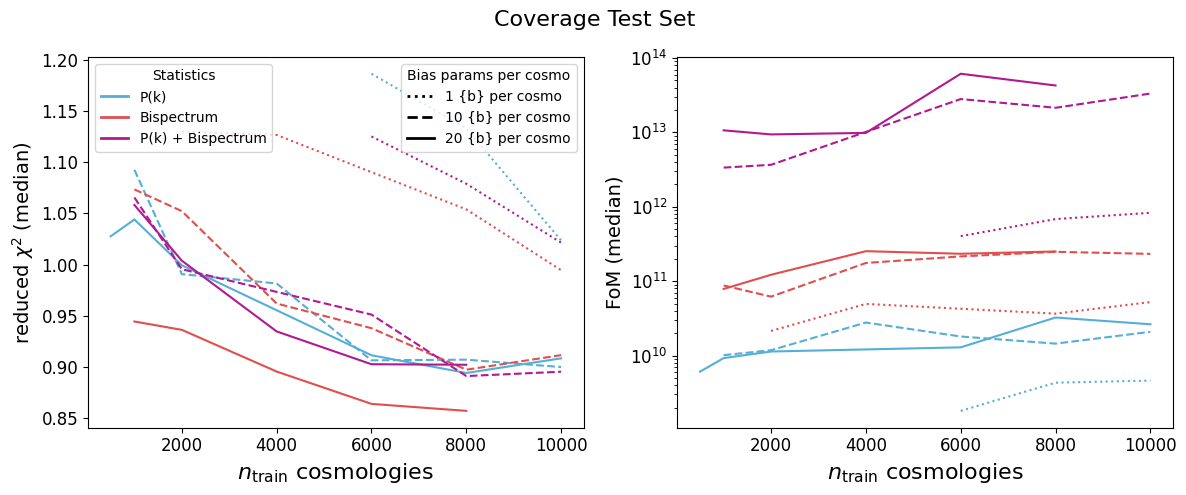

In [13]:
# --- Coverage plot in a separate cell ---
# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Coverage Test Set', fontsize=16)

n_train_ticks = n_train_arr[2:]

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(results_coverage_filtered.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    ax1.plot(n_train_arr_cov, np.median(chi2_coverage/n_dof, axis=1), marker=None, color=color, linestyle=linestyle)

ax1.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$ (median)', fontsize=14)
ax1.set_xticks(n_train_ticks)
ax1.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(results_coverage_filtered.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    ax2.plot(n_train_arr_cov, np.median(fom_coverage, axis=1), marker=None, color=color, linestyle=linestyle)

ax2.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM (median)', fontsize=14)
ax2.set_xticks(n_train_ticks)
ax2.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_yscale('log')

# Create separate legends (same as CV plots)
from matplotlib.lines import Line2D

# Color legend (statistics types)
color_legend_elements = [
    Line2D([0], [0], color=color_pk, lw=2, label='P(k)'),
    Line2D([0], [0], color=color_bispec, lw=2, label='Bispectrum'),
    Line2D([0], [0], color=color_pkbispec, lw=2, label='P(k) + Bispectrum')
]

# Linestyle legend (bias parameter counts)
# Get the bias parameter counts that are actually shown
shown_bias_tags = set()
for (statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov) in results_coverage_filtered.items():
    shown_bias_tags.add(tag_biasparams)

linestyle_legend_elements = []
bias_labels = {
    '_biaszen_p4_n10000': '1 {b} per cosmo',
    '_biaszen_p4_n50000': '5 {b} per cosmo',
    '_biaszen_p4_n100000': '10 {b} per cosmo',
    '_biaszen_p4_n200000': '20 {b} per cosmo'
}

for tag_bias in sorted(shown_bias_tags):
    if tag_bias in linestyle_map and tag_bias in bias_labels:
        linestyle_legend_elements.append(
            Line2D([0], [0], color='black', linestyle=linestyle_map[tag_bias], 
                   lw=2, label=bias_labels[tag_bias])
        )

# Add legends to the left subplot
legend1 = ax1.legend(handles=color_legend_elements, loc='upper left', fontsize=10, title='Statistics')
legend2 = ax1.legend(handles=linestyle_legend_elements, loc='upper right', fontsize=10, title='Bias params per cosmo')
ax1.add_artist(legend1)  # Add the first legend back

plt.tight_layout()
plt.show()

Found P(k) coverage data with tag: _biaszen_p4_n200000
Plotting coverage chi2 data: n_train = [500, 1000, 2000, 6000, 8000, 10000], chi2/n_dof (median) = [1.02766061 1.04413357 0.99936817 0.91131738 0.89396054 0.90830027]
Plotting coverage FoM data: n_train = [500, 1000, 2000, 6000, 8000, 10000], FoM (median) = [6.06319653e+09 9.24886286e+09 1.13257619e+10 1.28853158e+10
 3.24557223e+10 2.63340879e+10]


<Figure size 640x480 with 0 Axes>

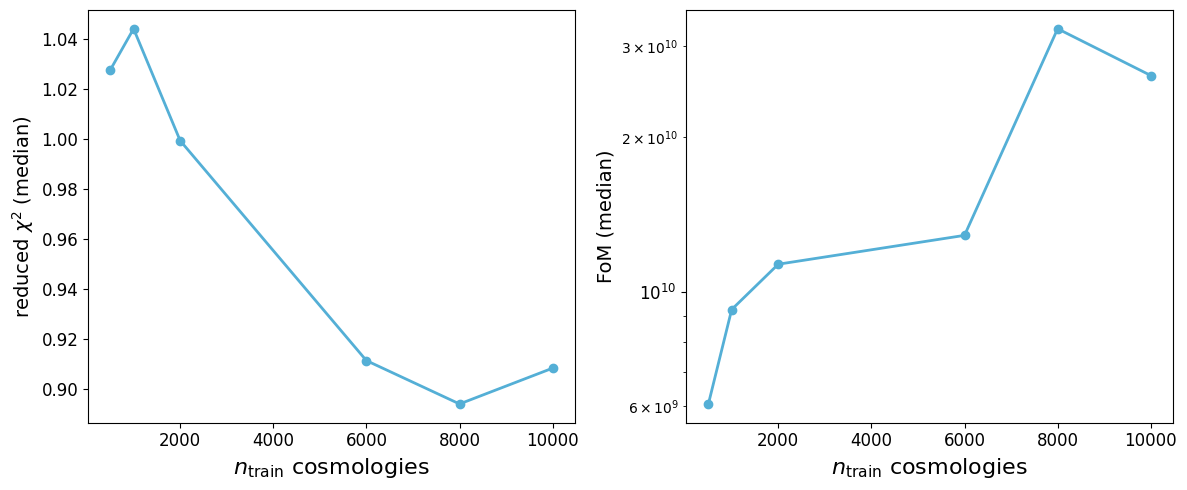

In [14]:
# --- Specialized coverage plot: P(k) only with 200 bias sets per cosmo ---
# Filter for only P(k) statistics and 200 bias sets per cosmology
coverage_pk_only_filter = {}
for key, value in results_coverage_filtered.items():
    statistics, tag_biasparams = key
    if statistics == ('pk',) and tag_biasparams == '_biaszen_p4_n200000':
        coverage_pk_only_filter[key] = value
        print(f"Found P(k) coverage data with tag: {tag_biasparams}")

# Check if we found any data
if not coverage_pk_only_filter:
    print("No P(k) coverage data found with _biaszen_p4_n200000 in filtered results")
    print("Available keys in results_coverage_filtered:")
    for key in results_coverage_filtered.keys():
        print(f"  {key}")
    
    # Try using unfiltered results
    for key, value in results_coverage.items():
        statistics, tag_biasparams = key
        if statistics == ('pk',) and tag_biasparams == '_biaszen_p4_n200000':
            coverage_pk_only_filter[key] = value
            print(f"Found P(k) coverage data in unfiltered results with tag: {tag_biasparams}")

# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

n_train_ticks = n_train_arr[2:]

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(coverage_pk_only_filter.items()):
    ax1.plot(n_train_arr_cov, np.median(chi2_coverage/n_dof, axis=1), marker='o', color=color_pk, linestyle='-', linewidth=2, markersize=6)
    print(f"Plotting coverage chi2 data: n_train = {n_train_arr_cov}, chi2/n_dof (median) = {np.median(chi2_coverage/n_dof, axis=1)}")

ax1.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$ (median)', fontsize=14)
ax1.set_xticks(n_train_ticks)
ax1.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(coverage_pk_only_filter.items()):
    ax2.plot(n_train_arr_cov, np.median(fom_coverage, axis=1), marker='o', color=color_pk, linestyle='-', linewidth=2, markersize=6)
    print(f"Plotting coverage FoM data: n_train = {n_train_arr_cov}, FoM (median) = {np.median(fom_coverage, axis=1)}")

ax2.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM (median)', fontsize=14)
ax2.set_xticks(n_train_ticks)
ax2.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

Found P(k) data with tag: _biaszen_p4_n200000
Plotting chi2 data: n_train = [500, 1000, 2000, 4000, 6000, 8000, 10000], chi2/n_dof = [0.40694276 0.45157791 0.34640939 0.42280608 0.27090471 0.33647493
 0.36355308]
Plotting FoM data: n_train = [500, 1000, 2000, 4000, 6000, 8000, 10000], FoM = [3.55619921e+09 4.32310853e+09 8.44977341e+09 7.98210426e+09
 6.22046510e+09 7.17670793e+09 7.84008257e+09]


<Figure size 640x480 with 0 Axes>

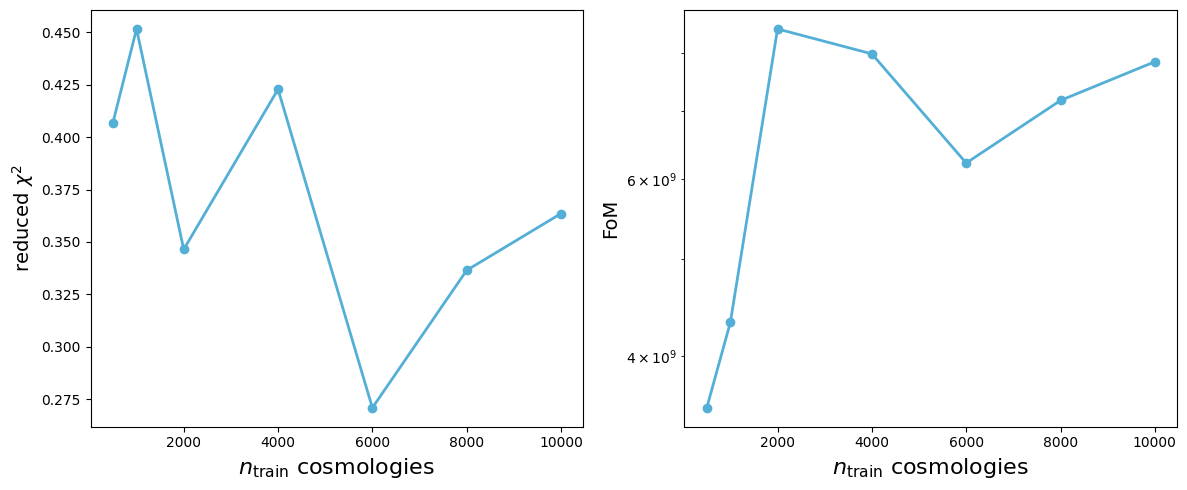

In [15]:
# --- Specialized plot: P(k) only with 200 bias sets per cosmo ---
# Filter for only P(k) statistics and 200 bias sets per cosmology
# This should match the data from the filtered results above, so let's use the same filtering

pk_only_filter = {}
for key, value in results_cv_filtered.items():
    statistics, tag_biasparams = key
    if statistics == ('pk',) and tag_biasparams == '_biaszen_p4_n200000':
        pk_only_filter[key] = value
        print(f"Found P(k) data with tag: {tag_biasparams}")

# Check if we found any data
if not pk_only_filter:
    print("No P(k) data found with _biaszen_p4_n200000 in filtered results")
    print("Available keys in results_cv_filtered:")
    for key in results_cv_filtered.keys():
        print(f"  {key}")
    
    # Try using unfiltered results
    for key, value in results_cv.items():
        statistics, tag_biasparams = key
        if statistics == ('pk',) and tag_biasparams == '_biaszen_p4_n200000':
            pk_only_filter[key] = value
            print(f"Found P(k) data in unfiltered results with tag: {tag_biasparams}")

# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(pk_only_filter.items()):
    ax1.plot(n_train_arr_cv, chi2_cv/n_dof, marker='o', color=color_pk, linestyle='-', linewidth=2, markersize=6)
    print(f"Plotting chi2 data: n_train = {n_train_arr_cv}, chi2/n_dof = {chi2_cv/n_dof}")

ax1.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$', fontsize=14)

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(pk_only_filter.items()):
    ax2.plot(n_train_arr_cv, fom_cv, marker='o', color=color_pk, linestyle='-', linewidth=2, markersize=6)
    print(f"Plotting FoM data: n_train = {n_train_arr_cv}, FoM = {fom_cv}")

ax2.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM', fontsize=14)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## Function of number of {b} sets

Showing bias parameter sets: [10000, 100000, 200000]


<Figure size 640x480 with 0 Axes>

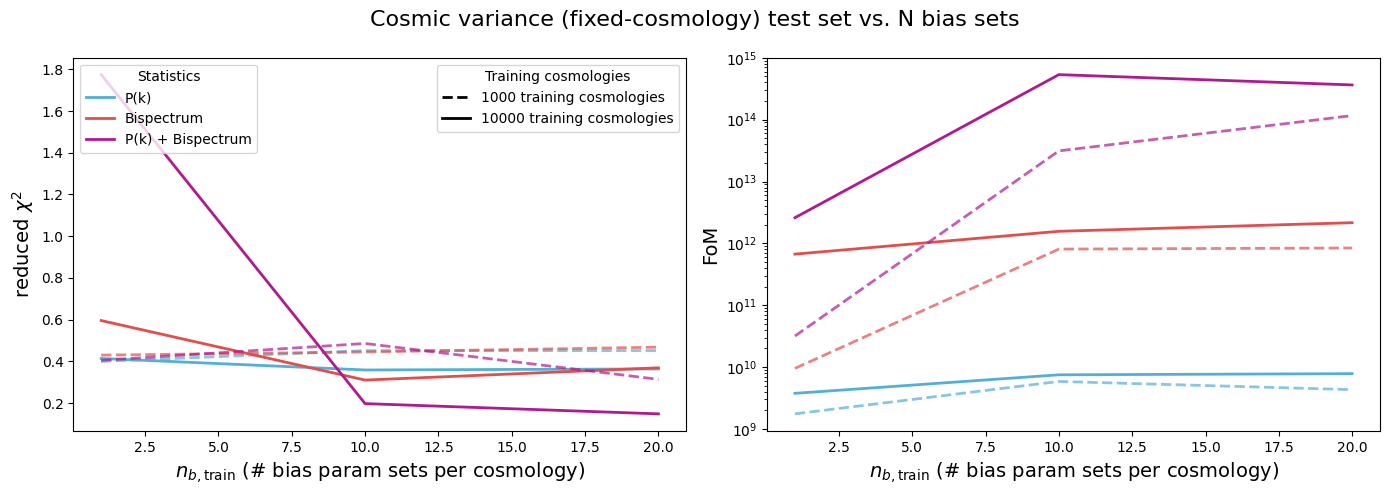

In [16]:
# --- Plot as function of number of bias parameter sets per cosmology ---
# Extract number of bias sets from tag_biasparams names
def get_n_bias_sets(tag_biasparams):
    # Extract the number from strings like '_biaszen_p4_n10000'
    return int(tag_biasparams.split('_n')[-1])

# Filter for specific ntrain values
ntrain_filter = [1000, 10000]

# Use the same bias filtering as configured above, but for the bias sets plots
# we need to include all bias sets to show the trend
bias_sets_to_show = bias_filter_values if bias_filter_values is not None else [1, 5, 10, 20]
bias_sets_filter = [n*10000 for n in bias_sets_to_show]  # Convert to actual numbers

print(f"Showing bias parameter sets: {bias_sets_filter}")

# Organize data by ntrain and statistics
cv_data_filtered = {}
coverage_data_filtered = {}

for (statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv) in results_cv.items():
    n_bias_sets = get_n_bias_sets(tag_biasparams)
    if n_bias_sets not in bias_sets_filter:
        continue
    for i, ntrain in enumerate(n_train_arr_cv):
        if ntrain in ntrain_filter:
            key = (tuple(statistics), ntrain)
            if key not in cv_data_filtered:
                cv_data_filtered[key] = {'n_bias_sets': [], 'chi2': [], 'fom': []}
            cv_data_filtered[key]['n_bias_sets'].append(n_bias_sets)
            cv_data_filtered[key]['chi2'].append(chi2_cv[i])
            cv_data_filtered[key]['fom'].append(fom_cv[i])

for (statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov) in results_coverage.items():
    n_bias_sets = get_n_bias_sets(tag_biasparams)
    if n_bias_sets not in bias_sets_filter:
        continue
    for i, ntrain in enumerate(n_train_arr_cov):
        if ntrain in ntrain_filter:
            key = (tuple(statistics), ntrain)
            if key not in coverage_data_filtered:
                coverage_data_filtered[key] = {'n_bias_sets': [], 'chi2': [], 'fom': []}
            coverage_data_filtered[key]['n_bias_sets'].append(n_bias_sets)
            coverage_data_filtered[key]['chi2'].append(np.median(chi2_coverage[i]))
            coverage_data_filtered[key]['fom'].append(np.median(fom_coverage[i]))

# Plot cosmic variance test set
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Cosmic variance (fixed-cosmology) test set vs. N bias sets', fontsize=16)

# Define linestyles and alpha for different ntrain values
ntrain_linestyle_map = {1000: '--', 10000: '-'}
alpha_map = {1000: 0.7, 10000: 1.0}

# Left subplot - Chi-squared
for (statistics, ntrain), data in cv_data_filtered.items():
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, 'black')
    linestyle = ntrain_linestyle_map.get(ntrain, '-')
    alpha = alpha_map.get(ntrain, 1.0)
    
    # Sort by n_bias_sets for proper line plotting
    sorted_indices = np.argsort(data['n_bias_sets'])
    n_bias_sorted = np.array(data['n_bias_sets'])[sorted_indices] / 10000
    chi2_sorted = np.array(data['chi2'])[sorted_indices]
    
    ax1.plot(n_bias_sorted, chi2_sorted/n_dof, linestyle=linestyle, color=color, 
             linewidth=2, alpha=alpha)

ax1.set_xlabel(r'$n_{b,\text{train}}$ (# bias param sets per cosmology)', fontsize=14)
ax1.set_ylabel('reduced $\\chi^2$', fontsize=14)

# Right subplot - FoM
for (statistics, ntrain), data in cv_data_filtered.items():
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, 'black')
    linestyle = ntrain_linestyle_map.get(ntrain, '-')
    alpha = alpha_map.get(ntrain, 1.0)
    
    # Sort by n_bias_sets for proper line plotting
    sorted_indices = np.argsort(data['n_bias_sets'])
    n_bias_sorted = np.array(data['n_bias_sets'])[sorted_indices] / 10000
    fom_sorted = np.array(data['fom'])[sorted_indices]
    
    ax2.plot(n_bias_sorted, fom_sorted, linestyle=linestyle, color=color, 
             linewidth=2, alpha=alpha)

ax2.set_xlabel(r'$n_{b,\text{train}}$ (# bias param sets per cosmology)', fontsize=14)
ax2.set_ylabel('FoM', fontsize=14)
ax2.set_yscale('log')

# Create separate legends
from matplotlib.lines import Line2D

# Color legend (statistics types)
color_legend_elements = [
    Line2D([0], [0], color=color_pk, lw=2, label='P(k)'),
    Line2D([0], [0], color=color_bispec, lw=2, label='Bispectrum'),
    Line2D([0], [0], color=color_pkbispec, lw=2, label='P(k) + Bispectrum')
]

# Linestyle legend (number of training cosmologies)
ntrain_legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='1000 training cosmologies'),
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='10000 training cosmologies')
]

# Add legends to the left subplot
legend1 = ax1.legend(handles=color_legend_elements, loc='upper left', fontsize=10, title='Statistics')
legend2 = ax1.legend(handles=ntrain_legend_elements, loc='upper right', fontsize=10, title='Training cosmologies')
ax1.add_artist(legend1)  # Add the first legend back

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

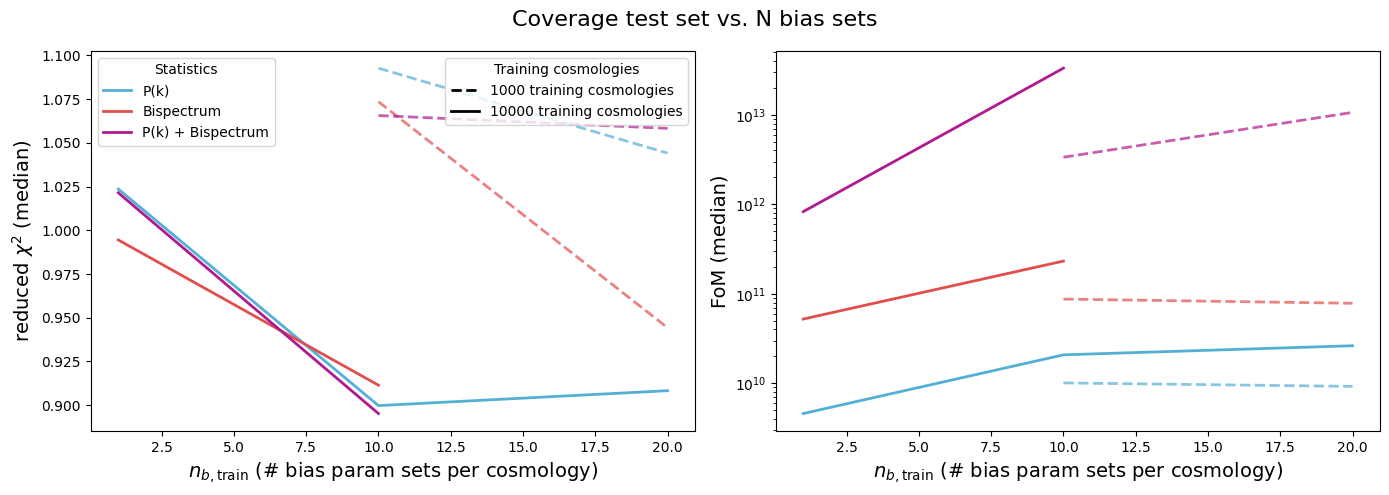

In [17]:
# Plot coverage test set
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Coverage test set vs. N bias sets', fontsize=16)

# Left subplot - Chi-squared
for (statistics, ntrain), data in coverage_data_filtered.items():
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, 'black')
    linestyle = ntrain_linestyle_map.get(ntrain, '-')
    alpha = alpha_map.get(ntrain, 1.0)
    
    # Sort by n_bias_sets for proper line plotting
    sorted_indices = np.argsort(data['n_bias_sets'])
    n_bias_sorted = np.array(data['n_bias_sets'])[sorted_indices] / 10000
    chi2_sorted = np.array(data['chi2'])[sorted_indices]
    
    ax1.plot(n_bias_sorted, chi2_sorted/n_dof, linestyle=linestyle, color=color, 
             linewidth=2, alpha=alpha)

ax1.set_xlabel(r'$n_{b,\text{train}}$ (# bias param sets per cosmology)', fontsize=14)
ax1.set_ylabel('reduced $\\chi^2$ (median)', fontsize=14)

# Right subplot - FoM
for (statistics, ntrain), data in coverage_data_filtered.items():
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, 'black')
    linestyle = ntrain_linestyle_map.get(ntrain, '-')
    alpha = alpha_map.get(ntrain, 1.0)
    
    # Sort by n_bias_sets for proper line plotting
    sorted_indices = np.argsort(data['n_bias_sets'])
    n_bias_sorted = np.array(data['n_bias_sets'])[sorted_indices] / 10000
    fom_sorted = np.array(data['fom'])[sorted_indices]
    
    ax2.plot(n_bias_sorted, fom_sorted, linestyle=linestyle, color=color, 
             linewidth=2, alpha=alpha)

ax2.set_xlabel(r'$n_{b,\text{train}}$ (# bias param sets per cosmology)', fontsize=14)
ax2.set_ylabel('FoM (median)', fontsize=14)
ax2.set_yscale('log')

# Create separate legends (same as CV bias sets plots)
from matplotlib.lines import Line2D

# Color legend (statistics types)
color_legend_elements = [
    Line2D([0], [0], color=color_pk, lw=2, label='P(k)'),
    Line2D([0], [0], color=color_bispec, lw=2, label='Bispectrum'),
    Line2D([0], [0], color=color_pkbispec, lw=2, label='P(k) + Bispectrum')
]

# Linestyle legend (number of training cosmologies)
ntrain_legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='1000 training cosmologies'),
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='10000 training cosmologies')
]

# Add legends to the left subplot
legend1 = ax1.legend(handles=color_legend_elements, loc='upper left', fontsize=10, title='Statistics')
legend2 = ax1.legend(handles=ntrain_legend_elements, loc='upper right', fontsize=10, title='Training cosmologies')
ax1.add_artist(legend1)  # Add the first legend back

plt.tight_layout()
plt.show()